In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from iminuit.cost import ExtendedBinnedNLL, LeastSquares
from iminuit import Minuit
from iminuit.util import describe, make_func_code
from scipy.interpolate import UnivariateSpline

In [3]:
datafile = '/home/manbing/Documents/Job_apply/circulate/returns.txt'

sum of r_t: -0.0017966390029566244
lenth: 1000


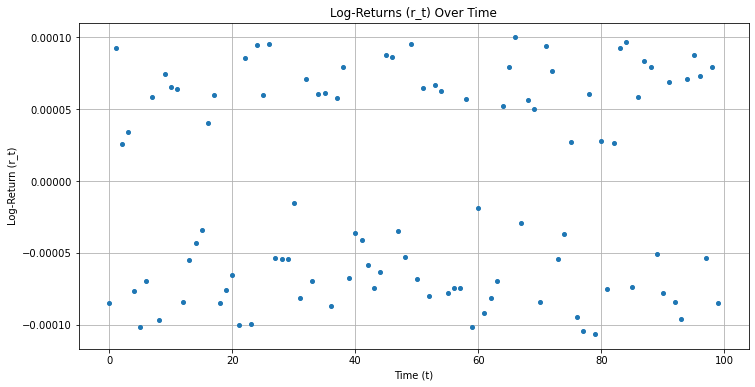

In [4]:
r = np.array([float(r_t) for r_t in open(f'{datafile}')])
print('sum of r_t:', sum(r))
print('lenth:', len(r))

plt.figure(figsize=(12, 6))
rp = pow(10, r[:50])
plt.plot(r[:100], marker='o', markersize=4, linestyle='None')

#plt.plot(r, marker='o', markersize=4)
plt.title('Log-Returns (r_t) Over Time')
plt.xlabel('Time (t)')
plt.ylabel('Log-Return (r_t)')
plt.grid(True)
plt.show()

I tried to solve the problem with chi-square fit, didn't work in this case, I guess the data need to be pre-processed or transfromed in some way to be fitted well. 
What I would also try is to limit the beta_k in a certain way that beta 1 to beta 20 are constrainted to a smooth function. 


(480, 20)
(480,)
[ 0.25433976 -0.39492639 -0.05211179  0.04407491  0.0520412   0.15405038
  0.24919132  0.21710269  0.02768712 -0.25814705 -0.3587034  -0.16550511
  0.05679038  0.18568281  0.23268392  0.22304235  0.13843896 -0.16746899
 -0.64124979  0.40327085]


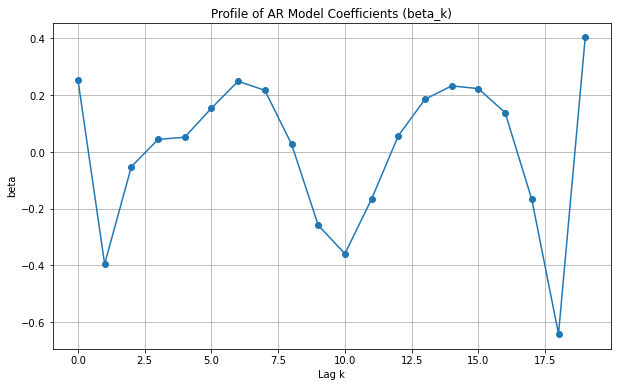

In [7]:
#number of k
nlag = 20

# Splitting the data into training and testing sets
train_data = r[:500]
test_data = r[500:]

# Function to create features for the AR model
def create_features(data, lag=20):
    X, y = [], []
    for i in range(lag, len(data)):
        X.append(data[i-lag:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Creating features and targets for training and testing sets
X_train, y_train = create_features(train_data)
X_test, y_test = create_features(test_data)

#sum_{k=1}^{20} beta_k * r_{t-k} + e_t,
xbeta = np.arange(1, nlag+1)

#This is the ARmodel to predict the future return given beta_k
def model_predict(x_matrix, beta_k):
    f_t = np.dot(beta_k, x_matrix)
    return f_t

#The AR model to fit training data to estimate the parameters beta_k
#As beta_k is smooth profile, we use spline function to fit the beta_k as function of k
def ModelAR(x_train, betak):
    spline_beta = UnivariateSpline(xbeta, betak, k=5, s=5)
    sp_betak = spline_beta(xbeta)
    f_t = np.dot(x_train, sp_betak)
    return f_t

# with this chisquare function we define the cost of the fit
class func_LeastSquares:
    def __init__(self, xdata, ydata, ydataerr):
        self.func_code = make_func_code([f'beta_{k}' for k in range(1, nlag+1)])
        self.xdata = xdata
        self.ydata = ydata
        self.ydataerr = ydataerr
        
    def __call__(self, *pars):
        betak = np.array(pars)
        predict_r = ModelAR(self.xdata, betak)
        chis = np.sum(((predict_r - self.ydata)/self.ydataerr)**2)
        #print(chis)
        return chis
    
#since in this data, we don't have any error, here we consider a 1% error as estimation
y_train_err = y_train * 0.001
print(X_train.shape)
print(y_train.shape)
cost = func_LeastSquares(X_train, y_train, y_train_err)

guess = {f'beta_{i}': 1 for i in range(1, nlag+1)}
#minize the cost function to estimate the beta
minuit = Minuit(cost, **guess)                                                                                                                                                                                                         
minuit.errordef = 1.0    
#for i in range(1, 21):
#    minuit.limits[f'beta_{i}'] = [0.01, 0.2]
    
minuit.migrad()                                                                                                                                                                                                                           
minuit.hesse()    

beta_k = minuit.values
merrs = minuit.errors
print(np.array(beta_k))
# Plotting the beta_k values
plt.figure(figsize=(10, 6))
plt.plot(beta_k, marker='o')
plt.title('Profile of AR Model Coefficients (beta_k)')
plt.xlabel('Lag k')
plt.ylabel('beta')
plt.grid(True)
plt.show()

    
